<a href="https://colab.research.google.com/github/mohsenmolaei/seriesnet_based/blob/main/seriesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet


In [2]:
import pdb
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.feature_selection import mutual_info_classif
# !pip install backtrader

# !pip install yfinance
import yfinance as yf
# !pip install lingam
# import feature_selection
import TSASeriesNet
# import feature_selection
if torch.cuda.is_available():
    # dev = "TPU:0"
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(device)

cuda:0


In [ ]:
data= pd.read_csv('data.csv')
data.set_index("time_stamp",inplace=True,drop=True)
# data
# label_encoder = LabelEncoder()
# n_bins = 50
# data['difficulty_latest'] = data['difficulty_latest'].astype(float)
# data['hash_rate_mean'] = data['hash_rate_mean'].astype(float)

# data['difficulty_latest'] = label_encoder.fit_transform(pd.cut(data['difficulty_latest'] , n_bins, retbins=True)[0])
# data['hash_rate_mean'] = label_encoder.fit_transform(pd.cut(data['hash_rate_mean'], n_bins, retbins=True)[0])

# whatcol=[ 'price_drawdown_relative','difficulty_latest',
#            'hash_rate_mean', 'active_more_1y_percent', 'utxo_created_value_median',
#            'transfers_volume_median', 'utxo_spent_value_median']

# X, Y = data.drop(["price_usd_close"],axis =1), np.array(data.price_usd_close) #data[whatcol]
# X.shape

In [ ]:
# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(data)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(X, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = col
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

# plt.show()

# # xindex = mi.sort_values(ascending=False)[0:8]
# # X = data[xindex.index]


In [ ]:
data_top15= pd.read_csv('top15.csv')
data_top15.set_index("time_stamp",inplace=True,drop=True)

# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(data_top15)

# label_encoder = LabelEncoder()
# n_bins = 50

# mi15= pd.DataFrame()
# mi15 = mutual_info_classif(data_top15, y_train)#, discrete_features=discrete_vars)
# mi15 = pd.Series(mi15)

# mi15.index = data_top15.columns
# mi15.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

# plt.show()

In [ ]:
# ccol = ['CL=F', 'CPI', 'DXYN', 'GC=F', 'SI=F', '^DJI', '^IXIC', '^RUT', '^TNX','EURUSD=X', 'GBPUSD=X', '^FTSE', 'N225']

Condition= pd.read_csv('Condition.csv')
Condition.set_index("time_stamp",inplace=True,drop=True)
# Condition

# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(Condition)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(Condition, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = Condition.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")
# plt.show()

# xindex = mi.sort_values(ascending=False)[0:8]
# Condition = data[xindex.index]

# Condition.columns

## SMA

In [3]:
def calculate_sma(data, window):
    sma_values = []
    for z in range(window-1):
      sma_values.append(0)
    for i in range(len(data) - window + 1):
        window_data = data[i : i + window]
        sma = sum(window_data) / window
        sma_values.append(sma)
    return sma_values


## MACD

In [4]:
def calculate_macd(data, short_window, long_window,Span):
    # Short term EMA
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    # Long term EMA
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    # Calculate MACD line
    MACD = short_ema - long_ema
    # Calculate Signal line
    Signal = MACD.ewm(span=Span, adjust=False).mean()
    return MACD,Signal


## VPT

In [5]:
def calculate_vpt(volume, close):
    vpt = pd.DataFrame(pd.Series(index=range(len(volume))))
    vpt.iloc[0] = 0  # Set the initial value of VPT to 0
    for i in range(1, len(volume)):
        vpt.iloc[i] = vpt.iloc[i-1] + (volume.iloc[i] * (close.iloc[i] - close.iloc[i-1])) / close.iloc[i-1]
    return vpt

# vpt = calculate_vpt(data['volume'], data['close'])

In [6]:
data_top15= pd.read_csv('top15_crypto.csv')
data_top15.set_index("time_stamp",inplace=True,drop=True)
cond = data_top15[:-1]
cond = cond.rename(columns={'BTC-USD': 'price_usd_close'})
cond = cond.fillna(method='ffill')

# cond = cond.drop(["AVAX-USD"],axis =1)
# cond = cond.drop(["AVAX-volume"],axis =1)
# cond = cond.drop(["DOT-USD"],axis =1)
# cond = cond.drop(["DOT-volume"],axis =1)
# cond = cond.drop(["MATIC-volume"],axis =1)
# cond = cond.drop(["MATIC-USD"],axis =1)
# cond = cond.drop(["USDC-USD"],axis =1)
# cond = cond.drop(["USDC-volume"],axis =1)
# cond = cond.drop(["USDT-USD"],axis =1)
# cond = cond.drop(["USDT-volume"],axis =1)
# cond = cond.drop(["SHIB-volume"],axis =1)
# cond = cond.drop(["SHIB-USD"],axis =1)

sma_list=["sma7", "sma7","sma30","sma60","sma90","sma120","sma180","sma210"]
col = list(cond.columns)+ list(sma_list)
cond_temp = pd.DataFrame(np.hstack((cond, pd.DataFrame(calculate_sma(cond["price_usd_close"],7 )))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],14 )))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],30)))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],60)))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],90)))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],120)))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],180)))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(calculate_sma(cond["price_usd_close"],210)))))
cond_temp.columns =col

macd_list=["MACD12","Signal12","MACD12","Signal26","vpt"]
col = list(cond_temp.columns)+ list(macd_list)
MACD12,Signal26=calculate_macd(cond["price_usd_close"], 12, 26,9)
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(MACD12))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(Signal26))))
MACD14,Signal30=calculate_macd(cond["price_usd_close"], 14, 30,9)
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(MACD14))))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(Signal30))))

vpt = calculate_vpt(pd.DataFrame(pd.DataFrame(cond['BTC-volume']).values), pd.DataFrame(pd.DataFrame(cond["price_usd_close"]).values))
cond_temp = pd.DataFrame(np.hstack((cond_temp, pd.DataFrame(vpt))))
cond_temp.columns =col

cond = cond_temp

<ipython-input-5-8e9113c05129>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vpt = pd.DataFrame(pd.Series(index=range(len(volume))))


In [7]:

test_df = cond.iloc[-1000:]
xtest = test_df.price_usd_close
condtest = test_df.drop("price_usd_close",axis=1)
# condtest =test_df#[f_col]
ytest = test_df.price_usd_close

cond = cond.iloc[:-1000]
Y = cond.price_usd_close
X = cond.price_usd_close
cond = cond.drop("price_usd_close",axis=1)

print(Y.shape,X.shape,cond.shape)
print(ytest.shape, xtest.shape , condtest.shape)

(16341,) (16341,) (16341, 42)
(1000,) (1000,) (1000, 42)


In [ ]:
# col = list(data.columns)+ list(Condition.columns)+list(data_top15.columns)
# cond = pd.DataFrame(np.hstack((data , Condition)))
# cond = pd.DataFrame(np.hstack((cond,data_top15)))
# cond.columns =col

# f_col = ["receiving_count", "^DJI"]

# import importlib
# import feature_selection
# importlib.reload(feature_selection)

# crypto = "price_usd_close"
# selectmx , matrix_correlation , matrix_observed , matrix_latent , matrix_granger , matrix_mi = feature_selection.select_matrix(cond, crypto)
# Y = cond.price_usd_close
# cond =cond.drop(["price_usd_close"],axis =1)


# selectmx.to_csv("select_matrix.csv")

# matrix_correlation.to_csv("matrix_correlation.csv")
# matrix_observed.to_csv("matrix_observed.csv")
# matrix_latent.to_csv("matrix_latent.csv")
# matrix_granger.to_csv("matrix_granger.csv")
# matrix_mi.to_csv("matrix_mi.csv")


# داده های تست روزهای اخیر
# test_data= pd.read_csv('test_data.csv')
# xtest = test_data.price_usd_close
# condtest = test_data[["receiving_count", "^DJI"]]
# ytest = test_data.price_usd_close


# test_df = cond.iloc[-200:]
# xtest = test_df.price_usd_close
# condtest = test_df.drop("price_usd_close",axis=1)
# # condtest =condtest#[f_col]
# ytest = test_df.price_usd_close

# cond = cond.iloc[:-200]
# Y = cond.price_usd_close
# X = cond.price_usd_close
# cond = cond.drop("price_usd_close",axis=1)


In [ ]:
# start = "2006-01-01"
# end="2023-3-28"
# indnas = ["^IXIC", "AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "NVDA", "PYPL", "ADBE", "NFLX", "INTC", "CSCO", "CMCSA", "AMD", "PEP", "CHTR", "TMUS", "AVGO", "GILD", "AMGN", "QCOM", "JD", "TXN", "BIIB", "VRTX", "REGN", "ISRG", "MRNA", "COST", "BKNG", "ADP"]
# try :
#     data_top_index = yf.download(indnas ,start=start, end=end , interval ="1d") #1137
# except Exception as e:
#     print("error")
# data_top_index.set_index(pd.to_datetime(data_top_index.index).date,inplace=True)
# data_top_index = data_top_index.Close.fillna(method='ffill')

# try:
#     data_crypto = yf.download("BTC-USD" ,start=start, end=end , interval ="1d")
# except Exception as e:
#     print("error")
# data_crypto.set_index(pd.to_datetime(data_crypto.index).date,inplace=True)

# merged_df = pd.merge(data_crypto.Close, data_top_index , left_index=True, right_index=True, how='outer')
# merged_df.fillna(method='bfill', inplace=True)

# merged_df = merged_df.rename_axis('time_stamp')

# merged_df.to_csv("nasdaq.csv")

In [ ]:
# داده های مقاله
data_top_index= pd.read_csv('nasdaq100_padding.csv')

test_df = data_top_index.iloc[-8180:] #8180
cond = data_top_index.iloc[:-8180]
Y = cond["NDX"]
X = cond["NDX"]
# cond = cond.drop("NVDA",axis=1)
cond = cond.drop("NDX",axis=1)

xtest = test_df["NDX"]
ytest = test_df["NDX"]
condtest = test_df.drop("NDX",axis=1)
# condtest = condtest.drop("NDX",axis=1)

f_col = col= condtest.columns.values


In [ ]:
# # start = "2023-04-01"
# # end="2023-5-09"
# data_top_index= pd.read_csv('nasdaq.csv')
# data_top_index.set_index("time_stamp",inplace=True,drop=True)
# # data_top_index = data_top_index[['^IXIC','AAPL','GOOGL','AMZN', 'MRVL', 'MSFT',]]
# # Y = data_top_index["^IXIC"]
# # data_top_index = data_top_index.drop("^IXIC",axis =1)

# # autoscaler = StandardScaler()
# # features = autoscaler.fit_transform(data_top_index)

# # label_encoder = LabelEncoder()
# # n_bins = 50
# # y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# # mi= pd.DataFrame()
# # mi = mutual_info_classif(data_top_index, y_train)#, discrete_features=discrete_vars)
# # mi = pd.Series(mi)

# # mi.index = data_top_index.columns
# # mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# # plt.ylabel('Mutual Information')
# # plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")
# # plt.show()
# test_df = data_top_index.iloc[-430:]
# cond = data_top_index.iloc[:-430]
# Y = cond["AAPL"]
# X = cond["^IXIC"]
# cond = cond.drop("AAPL",axis=1)
# cond = cond.drop("^IXIC",axis=1)

# xtest = test_df["^IXIC"]
# ytest = test_df["AAPL"]
# condtest = test_df.drop("AAPL",axis=1)
# condtest = condtest.drop("^IXIC",axis=1)

# f_col = col= condtest.columns.values


In [ ]:
import pandas as pd
import numpy as np

def calculate_rsi(data, window_length):
    # Calculate the price differences
    delta = data.diff()

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA (Exponential Weighted Moving Average) of the gains and losses
    gain_avg = up.ewm(span=window_length).mean()
    loss_avg = down.abs().ewm(span=window_length).mean()

    # Calculate the Relative Strength (RS)
    rs = gain_avg / loss_avg

    # Calculate the RSI
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

# Calculate the RSI with a window length of 14 days
X = calculate_rsi(X, window_length=14)
X.fillna(method='bfill', inplace=True)

xtest = calculate_rsi(xtest, window_length=14)
xtest.fillna(method='bfill', inplace=True)

# Print the RSI values
print(xtest)


32380     0.000000
32381     0.000000
32382     0.000000
32383     4.363515
32384    27.517971
           ...    
40555    64.311538
40556    60.550920
40557    63.768070
40558    72.750859
40559    72.614326
Name: NDX, Length: 8180, dtype: float64


### **SMA**

**TEST data**

In [8]:
"""# scale features"""
from sklearn.preprocessing import  MinMaxScaler
MMScaler = MinMaxScaler()
SScaler = MinMaxScaler()
condscaler = MinMaxScaler()

MMScaler_test = MinMaxScaler()
SScaler_test = MinMaxScaler()
condscaler_test = MinMaxScaler()

# train and validation data scaler
X_trans = SScaler.fit_transform(pd.DataFrame(np.array(Y).reshape(-1, 1)))#Y.reshape(-1, 1))
condtemp = cond
c_trans = condscaler.fit_transform(condtemp)#[f_col])

# for i in range(0,len(selectmx.T)):
#   col2 = c_trans[:,i].copy()
#   if selectmx.T["price_usd_close"][i] >= max(selectmx.T["price_usd_close"])  :
#     print(col[i])
#     col2 *= selectmx.T["price_usd_close"][i]/max(selectmx.T["price_usd_close"])
#   else:
#     col2 *= 0
# #   c_trans[:, i] = col2
# print("\n\n")

# for i in range(0,len(result_df.T)):
#   col2 = c_trans[:,i].copy()
#   if result_df.squeeze().tolist()[i] >= 1:
#     print(col[i])
#     col2 *= result_df.T[i]
#   else:
#     col2 *= 0
#   c_trans[:, i] = col2
# print("\n\n")

# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col2.all() == 0)], axis=1)


# for i in range(0,len(selectmx.T)):
#   col2 = c_trans[:,i].copy()
#   if selectmx.T["Close"][i] >= max(selectmx.T["Close"]) -4:
#     print(col[i])
#     col2 *= selectmx.T["Close"][i]/max(selectmx.T["Close"])
#   else:
#     col2 *= 0
#   c_trans[:, i] = col2
# print("\n\n")
# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col.all() == 0)], axis=1)


y_trans = MMScaler.fit_transform(pd.DataFrame(np.array(Y).reshape(-1, 1)))
print(X_trans.shape)
print(c_trans.shape)
print(y_trans.shape)

# Test data Scaler
X_trans_test = SScaler_test.fit_transform(xtest.values.reshape(-1, 1))
c_trans_test = condscaler_test.fit_transform(condtest)
y_trans_test = MMScaler_test.fit_transform(ytest.values.reshape(-1, 1))

"""# split a multivariate sequence past, future samples (X and y)"""
def split_sequences(input_sequences, condition_seq, output_sequence, n_steps_in, n_steps_out):
    X, C, y = list(),list(), list()
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix >= len(input_sequences): break
        seq_x, seq_c, seq_y = input_sequences[i:end_ix], condition_seq[i:end_ix], output_sequence[end_ix:out_end_ix]
        X.append(seq_x), C.append(seq_c) ,y.append(seq_y)
    return np.array(X), np.array(C), np.array(y)


x_shape = 60
y_shape = 7
# Train data
X_ss, C_ss, y_mm = split_sequences(X_trans, c_trans, y_trans, x_shape, y_shape)
print(X_ss.shape, C_ss.shape, y_mm.shape)

#Test data
DataX_test, DataC_test, Datay_test = split_sequences(X_trans_test, c_trans_test, y_trans_test, x_shape, y_shape)

total_samples = len(cond)
train_test_cutoff = round(0.8 * total_samples) # 0.8

X_train = X_ss[:-(total_samples-train_test_cutoff)]
C_train = C_ss[:-(total_samples-train_test_cutoff)]
X_test = X_ss[-(total_samples-train_test_cutoff):]
C_test = C_ss[-(total_samples-train_test_cutoff):]

y_train = y_mm[:-(total_samples-train_test_cutoff)]
y_test = y_mm[-(total_samples-train_test_cutoff):]

# Randomly shuffle the indices
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# Reorder the data using the shuffled indices
X_train = X_train[indices]
C_train = C_train[indices]
y_train = y_train[indices]

print(total_samples - train_test_cutoff)
print("Training Shape:", X_train.shape, y_train.shape)
print("Validatin Shape:", X_test.shape, y_test.shape)

"""# convert to pytorch tensors"""
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
X_test_tensors = Variable(torch.Tensor(X_test).to(device))

C_train_tensors = Variable(torch.Tensor(C_train).to(device))
C_test_tensors = Variable(torch.Tensor(C_test).to(device))

y_train_tensors = Variable(torch.Tensor(y_train).to(device))
y_test_tensors = Variable(torch.Tensor(y_test).to(device))

print(X_train_tensors.shape)
print(C_train_tensors.shape)

# DataX_test, DataC_test, Datay_test
DataX_test = Variable(torch.Tensor(DataX_test).to(device))
DataC_test = Variable(torch.Tensor(DataC_test).to(device))
Datay_test = Variable(torch.Tensor(Datay_test).to(device))

"""# reshaping to rows, timestamps, features"""

X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], x_shape,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], x_shape,
                                      X_test_tensors.shape[2]))

C_train_tensors_final = torch.reshape(C_train_tensors,
                                      (C_train_tensors.shape[0], x_shape,
                                       C_train_tensors.shape[2]))
C_test_tensors_final = torch.reshape(C_test_tensors,
                                     (C_test_tensors.shape[0], x_shape,
                                      C_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, C_train_tensors_final.shape, y_train_tensors.shape)
print("Validation Shape:", X_test_tensors_final.shape, C_test_tensors_final.shape, y_test_tensors.shape)
print("Test Shape:", DataX_test.shape, DataC_test.shape, Datay_test.shape)


(16341, 1)
(16341, 42)
(16341, 1)
(16274, 60, 1) (16274, 60, 42) (16274, 7, 1)
3268
Training Shape: (13006, 60, 1) (13006, 7, 1)
Validatin Shape: (3268, 60, 1) (3268, 7, 1)
torch.Size([13006, 60, 1])
torch.Size([13006, 60, 42])
Training Shape: torch.Size([13006, 60, 1]) torch.Size([13006, 60, 42]) torch.Size([13006, 7, 1])
Validation Shape: torch.Size([3268, 60, 1]) torch.Size([3268, 60, 42]) torch.Size([3268, 7, 1])
Test Shape: torch.Size([933, 60, 1]) torch.Size([933, 60, 42]) torch.Size([933, 7, 1])


In [9]:
# %%
def NRMSELoss(yhat,y): #NRMSE
  y = y.reshape(y.shape[0], y.shape[1])
  return (torch.sqrt(torch.mean(torch.square(yhat-y))))/ (torch.max(y) - torch.min(y))

# Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_pred,y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

def MAPELoss(yhat,y):
  y = y.reshape(y.shape[0], y.shape[1])
  return torch.mean(torch.abs(yhat-y)/torch.abs(y))

def SMAPELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = 2 * torch.mean(torch.abs(y_true - y_pred) / (torch.max(y_true) + torch.max(y_true)))
  return loss

def MSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.mean((y_pred - y_true)**2)
  return loss

def RMSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.sqrt(torch.mean((y_pred - y_true)**2))
  return loss

def RMSLELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.sqrt(torch.mean((torch.log(y_pred+1) - torch.log(y_true+1))**2))
  return loss

In [10]:
# !pip install tensorboard
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('logs')

# def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=200):
#     lr = init_lr * (0.9**(epoch // lr_decay_epoch))
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr
#     return optimizer

from torch.utils.data import TensorDataset, DataLoader

def training_loop(n_epochs, learning_rate, lr_decay_epoch, network, optimiser, loss_fn, X_train, Condition_train, y_train, X_test, Condition_test, y_test, batch_size):
    loss_valid_show, loss_train_show = [], []

    if torch.cuda.is_available():
        network.cuda()

    best_valid_loss = float('inf')
    best_epoch = -1

    # Split data into batches
    train_loader = DataLoader(TensorDataset(X_train, Condition_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, Condition_test, y_test), batch_size=batch_size)

    for epoch in range(n_epochs):
        network.train()
        train_loss = 0.0
        for i, (X_batch, Condition_batch, y_batch) in enumerate(train_loader):
            optimiser.zero_grad()
            outputs = network.forward(X_batch, Condition_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()

        # Calculate average training loss across batches
        train_loss /= len(train_loader)

        network.eval()
        test_loss = 0.0
        with torch.no_grad():
            for i, (X_batch, Condition_batch, y_batch) in enumerate(test_loader):
                outputs = network.forward(X_batch, Condition_batch)
                loss = loss_fn(outputs, y_batch)
                test_loss += loss.item()

        # Calculate average testing loss across batches
        test_loss /= len(test_loader)

        loss_valid_show.append(test_loss)
        loss_train_show.append(train_loss)


        if test_loss < best_valid_loss:
            best_valid_loss = test_loss
            best_epoch = epoch
            torch.save({'epoch': epoch, 'state_dict': network.state_dict()}, f'./weights/model_epoch_{epoch}.pth')

        if (epoch) % (10) == 0:
            print("Epoch: %4d, Train loss: %1.5f, Validation loss: %1.5f" % (epoch, train_loss, test_loss))

    # writer.close()
    return loss_train_show, loss_valid_show, best_valid_loss, best_epoch


In [ ]:
"""# Training"""

import torch
import gc
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

124

In [18]:
# torch.manual_seed(17)
# torch.cuda.manual_seed(17)
# np.random.seed(17)
# torch.backends.cudnn.deterministic=True

import importlib
import Decoder_DARLM
import Encoder_DARLM
import ts_lstm
import ts_gru
import HSAM
import CBAM
import GDCN_Encoder
import GDCN_Decoder
# import lstm_gru_model
# import sfm
# import sfm_test
importlib.reload(GDCN_Encoder)
importlib.reload(GDCN_Decoder)

importlib.reload(CBAM)
importlib.reload(Decoder_DARLM)
importlib.reload(TSASeriesNet)
importlib.reload(Encoder_DARLM)
importlib.reload(ts_lstm)
importlib.reload(ts_gru)
importlib.reload(HSAM)
# importlib.reload(lstm_gru_model)
# importlib.reload(sfm)
# importlib.reload(sfm_test)
n_epochs = 121
num_inputs = X_train_tensors_final.shape[1]
dilation_c = 2
kernel_size_EN = 2
kernel_size_DE = 4
hidden_size_lstm =5
hidden_size_gru = 5
num_levels_en = 6
num_levels_de = 8
num_layers_lstm = 3
num_layers_gru = 3
features = X_train_tensors_final.shape[2]
features_c = C_train_tensors_final.shape[2]
output_num = y_train_tensors.shape[1]

lr_decay_epoch = 49
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
loss_fn = RMSELoss #SMAPELoss #MAPELoss #NRMSELoss #rmspe #RMSELoss #### RMSLELoss
# ANN model
myModel = TSASeriesNet.ANNmodel(num_inputs, features_c, features, output_num, num_levels_en,num_levels_de, kernel_size_EN, kernel_size_DE, dilation_c, hidden_size_lstm, hidden_size_gru, num_layers_lstm, num_layers_gru ).to(device)
optimiser = torch.optim.Adam(myModel.parameters())#,weight_decay=weight_decay)#, lr=learning_rate)#, eps=1e-08)#

loss_train_show ,loss_valid_show , best_valid_loss , best_epoch= training_loop(n_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  lr_decay_epoch = lr_decay_epoch,
                                  network=myModel,
                                  optimiser=optimiser,
                                  loss_fn=loss_fn,
                                  X_train=X_train_tensors_final,
                                  Condition_train = C_train_tensors_final,
                                  y_train=y_train_tensors,
                                  X_test=X_test_tensors_final,
                                  Condition_test  = C_test_tensors_final,
                                  y_test=y_test_tensors,
                                  batch_size = batch_size)

print(f"best validation loss: {best_valid_loss} in epoch {best_epoch}")

Epoch:    0, Train loss: 0.14239, Validation loss: 0.14231
Epoch:   10, Train loss: 0.01733, Validation loss: 0.01762
Epoch:   20, Train loss: 0.01499, Validation loss: 0.00993
Epoch:   30, Train loss: 0.01457, Validation loss: 0.00708
Epoch:   40, Train loss: 0.01427, Validation loss: 0.00704
Epoch:   50, Train loss: 0.01269, Validation loss: 0.00848
Epoch:   60, Train loss: 0.01190, Validation loss: 0.00516
Epoch:   70, Train loss: 0.01158, Validation loss: 0.00898
Epoch:   80, Train loss: 0.01083, Validation loss: 0.01048
Epoch:   90, Train loss: 0.01105, Validation loss: 0.00824
Epoch:  100, Train loss: 0.01130, Validation loss: 0.00773
Epoch:  110, Train loss: 0.01049, Validation loss: 0.01068
Epoch:  120, Train loss: 0.01022, Validation loss: 0.00625
best validation loss: 0.005159524347758493 in epoch 60


In [22]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])

# with torch.no_grad():
#   test_predict = myModel(DataX_test, DataC_test)  # get the last sample
# test_predict = test_predict.detach().cpu().numpy()
# test_predict = MMScaler_test.inverse_transform(test_predict)

# test_target = Datay_test.detach().cpu().numpy()  # last sample again

with torch.no_grad():
  test_predict = myModel(DataX_test, DataC_test)  # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_target = Datay_test.detach().cpu().numpy()  # last sample again

def NRMSELoss_test(yhat,y): #NRMSE
  return np.sqrt(np.mean(np.square(yhat-y)))

def RMSELoss_test(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = np.sqrt(np.mean((y_pred - y_true)**2))
  return loss

def RMSLELoss_test(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = np.sqrt(np.mean((np.log(y_pred+1) - np.log(y_true+1))**2))
  return loss

def MSELoss_test(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = np.mean((y_pred - y_true)**2)
  return loss

# NRMSELoss_res = NRMSELoss_test(test_predict[:,0] ,first_day_test_target.reshape(-1) )
NRMSELoss_res = NRMSELoss_test(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )
RMSELoss_res = RMSELoss_test(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )
MSELoss_res = MSELoss_test(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )
RMSLELoss_res = RMSLELoss_test(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )

print(f"NRMSELoss_test: ",NRMSELoss_res)
print(f"RMSELoss: ", RMSELoss_res)
print(f"MSELoss: ",MSELoss_res)
print(f"RMSLELoss:",RMSLELoss_res)

NRMSELoss_test:  0.04079426
RMSELoss:  0.04079426
MSELoss:  0.0016641718
RMSLELoss: 0.030721039


In [23]:
import sklearn.metrics as smet
def RegressionReport(Y:np.ndarray, P:np.ndarray) -> None:
    MSE = smet.mean_squared_error(Y, P)
    RMSE = MSE ** 0.5
    Range = Y.max() - Y.min()
    NRMSE = 100 * RMSE / Range
    MAE = smet.mean_absolute_error(Y, P)
    NMAE = 100 * MAE / Range
    MAPE = 100 * smet.mean_absolute_percentage_error(Y, P)
    R2 = 100 * smet.r2_score(Y, P)
    print('_' * 60)
    print(f'Model Regression Report For Dataset:')
    print(f'MSE: {MSE:.6f}')
    print(f'RMSE: {RMSE:.6f}')
    print(f'NRMSE: {NRMSE:.4f} %')
    print(f'MAE: {MAE:.6f}')
    print(f'NMAE: {NMAE:.4f} %')
    print(f'MAPE: {MAPE:.4f} %')
    print(f'R2: {R2:.4f} %')
    print('_' * 60)
RegressionReport(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )

____________________________________________________________
Model Regression Report For Dataset:
MSE: 0.001664
RMSE: 0.040794
NRMSE: 4.4057 %
MAE: 0.025182
NMAE: 2.7196 %
MAPE: 11.5892 %
R2: 96.4924 %
____________________________________________________________


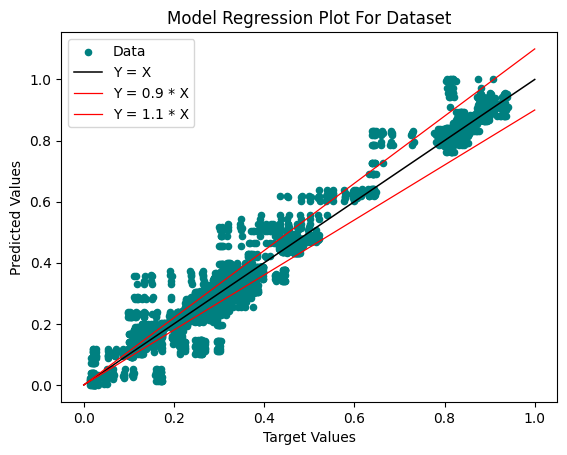

In [25]:
def RegressionPlot(Y:np.ndarray, P:np.ndarray) -> None:
    a = min(Y.min(), P.min())
    b = max(Y.max(), P.max())
    ab = np.array([a, b], dtype=np.float32)
    plt.scatter(Y, P, s=20, c='teal', marker='o', label='Data')
    plt.plot(ab, ab, ls='-', lw=1.1, c='k', label='Y = X')
    plt.plot(ab, 0.9 * ab, ls='-', lw=0.9, c='r', label='Y = 0.9 * X')
    plt.plot(ab, 1.1 * ab, ls='-', lw=0.9, c='r', label='Y = 1.1 * X')
    plt.title(f'Model Regression Plot For Dataset')
    plt.xlabel('Target Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

RegressionPlot(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]))

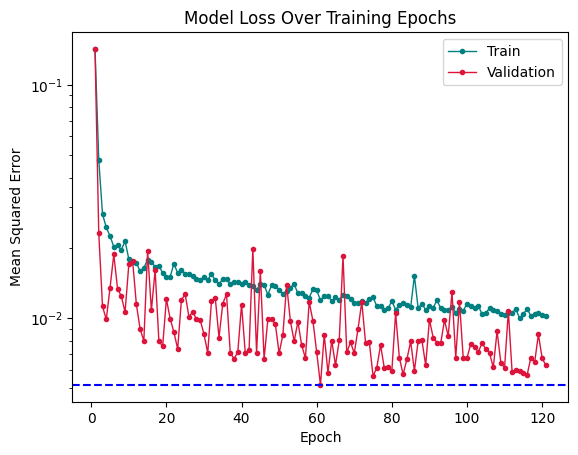

In [30]:
def PlotLoss(History:dict) -> None:
    nEpoch = len(History['loss'])
    Epochs = np.arange(start=1, stop=nEpoch + 1, step=1)
    plt.plot(Epochs, History['loss'], ls='-', lw=1, c='teal', marker='o', ms=3, label='Train')
    plt.plot(Epochs, History['val_loss'], ls='-', lw=1, c='crimson', marker='o', ms=3, label='Validation')
    plt.axhline(y=np.min(History['val_loss']), color='b', linestyle='--')

    plt.title('Model Loss Over Training Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.yscale('log')
    plt.legend()
    plt.show()

History ={'loss':loss_train_show ,'val_loss':loss_valid_show }
PlotLoss(History)

**ARIMA**

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have preprocessed training data X_trans and y_trans

# Train-test split
train_size = int(len(X_trans) * 0.8)  # 80% train, 20% test
X_train, X_test = X_trans[:train_size], X_trans[train_size:]
y_train, y_test = y_trans[:train_size], y_trans[train_size:]

# Fit ARIMA model
model = ARIMA(endog=y_train, exog=X_train, order=(2, 0, 1))  # Adjust the order as needed
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)[0]

# Evaluate forecast

def NRMSELoss_test(yhat,y): #NRMSE
  return np.sqrt(np.mean(np.square(yhat-y)))

def RMSELoss_test(y_pred, y_true):
  loss = np.sqrt(np.mean((y_pred - y_true)**2))
  return loss

def RMSLELoss_test(y_pred, y_true):
  loss = np.sqrt(np.mean((np.log(y_pred+1) - np.log(y_true+1))**2))
  return loss

def MSELoss_test(y_pred, y_true):
  loss = np.mean((y_pred - y_true)**2)
  return loss

def RMSLELoss(y_pred, y_true):
  loss = np.sqrt(np.mean((np.log(y_pred+1) - np.log(y_true+1))**2))
  return loss

print(f"RMSLELoss:",RMSLELoss(forecast, y_test))

# Predict future values  y_trans_test
future_X = X_trans_test  # Exogenous variables for future prediction
future_forecast = model_fit.forecast(steps=len(future_X), exog=future_X)[0]
print("\nTest Data")
print(f"NRMSELoss_test: ",NRMSELoss_test(forecast, y_test))
print(f"RMSELoss: ", RMSELoss_test(forecast, y_test))
print(f"MSELoss: ",MSELoss_test(forecast, y_test))
print(f"RMSLELoss:",RMSLELoss(future_forecast, y_trans_test))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSLELoss: 0.15140163028052436

Test Data
NRMSELoss_test:  0.16878199701982594
RMSELoss:  0.16878199701982594
MSELoss:  0.02848736251800053
RMSLELoss: 0.14971693991270696


**SARIMAX**

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming you have preprocessed training data X_trans and y_trans

# Train-test split
train_size = int(len(X_trans) * 0.8)  # 80% train, 20% test
X_train, X_test = X_trans[:train_size], X_trans[train_size:]
y_train, y_test = y_trans[:train_size], y_trans[train_size:]

# Fit SARIMAX model
model = SARIMAX(endog=y_train, exog=c_trans[:train_size], order=(2, 0, 1))  # Adjust the order as needed
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(X_test), exog=c_trans[train_size:])[0]

# Evaluate forecast

def NRMSELoss_test(yhat, y): #NRMSE
    return np.sqrt(np.mean(np.square(yhat-y)))

def RMSELoss_test(y_pred, y_true):
    loss = np.sqrt(np.mean((y_pred - y_true)**2))
    return loss

def RMSLELoss_test(y_pred, y_true):
    loss = np.sqrt(np.mean((np.log(y_pred+1) - np.log(y_true+1))**2))
    return loss

def MSELoss_test(y_pred, y_true):
    loss = np.mean((y_pred - y_true)**2)
    return loss

def RMSLELoss(y_pred, y_true):
    loss = np.sqrt(np.mean((np.log(y_pred+1) - np.log(y_true+1))**2))
    return loss

print("RMSLELoss:", RMSLELoss(forecast, y_test))
# Predict future values y_trans_test
future_X = X_trans_test  # Exogenous variables for future prediction
future_forecast = model_fit.forecast(steps=len(future_X), exog=c_trans_test)[0]
print("\nTest Data")
print("NRMSELoss_test:", NRMSELoss_test(forecast, y_test))
print("RMSELoss:", RMSELoss_test(forecast, y_test))
print("MSELoss:", MSELoss_test(forecast, y_test))
print("RMSLELoss:", RMSLELoss(future_forecast, y_trans_test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSLELoss: 0.15051051033850327

Test Data
NRMSELoss_test: 0.16788119279038569
RMSELoss: 0.16788119279038569
MSELoss: 0.028184094892722646
RMSLELoss: 0.14863473711030578


In [ ]:
# checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth', map_location=torch.device('cpu'))
# myModel.load_state_dict(checkpoint['state_dict'])

# for i in range(num_levels_en):
#     weights = pd.DataFrame(myModel.en_darlm.network[i].pointwise_conv.weight.cpu().detach().numpy().reshape(myModel.en_darlm.network[i].pointwise_conv.weight.size(0), -1))
#     row_means = np.mean((weights), axis=1)
#     row_means_df = pd.DataFrame(row_means)
#     row_means_df.index = col
#     result_df = np.tanh(row_means_df) #row_means_df.applymap(lambda x: 1 if x > row_means_df[0].mean() else 0 if x == row_means_df[0].mean() else 0)
#     # print(result_df)
#     result_df.to_csv(f"causal/pointwise_conv_weights_mean{i}.csv")


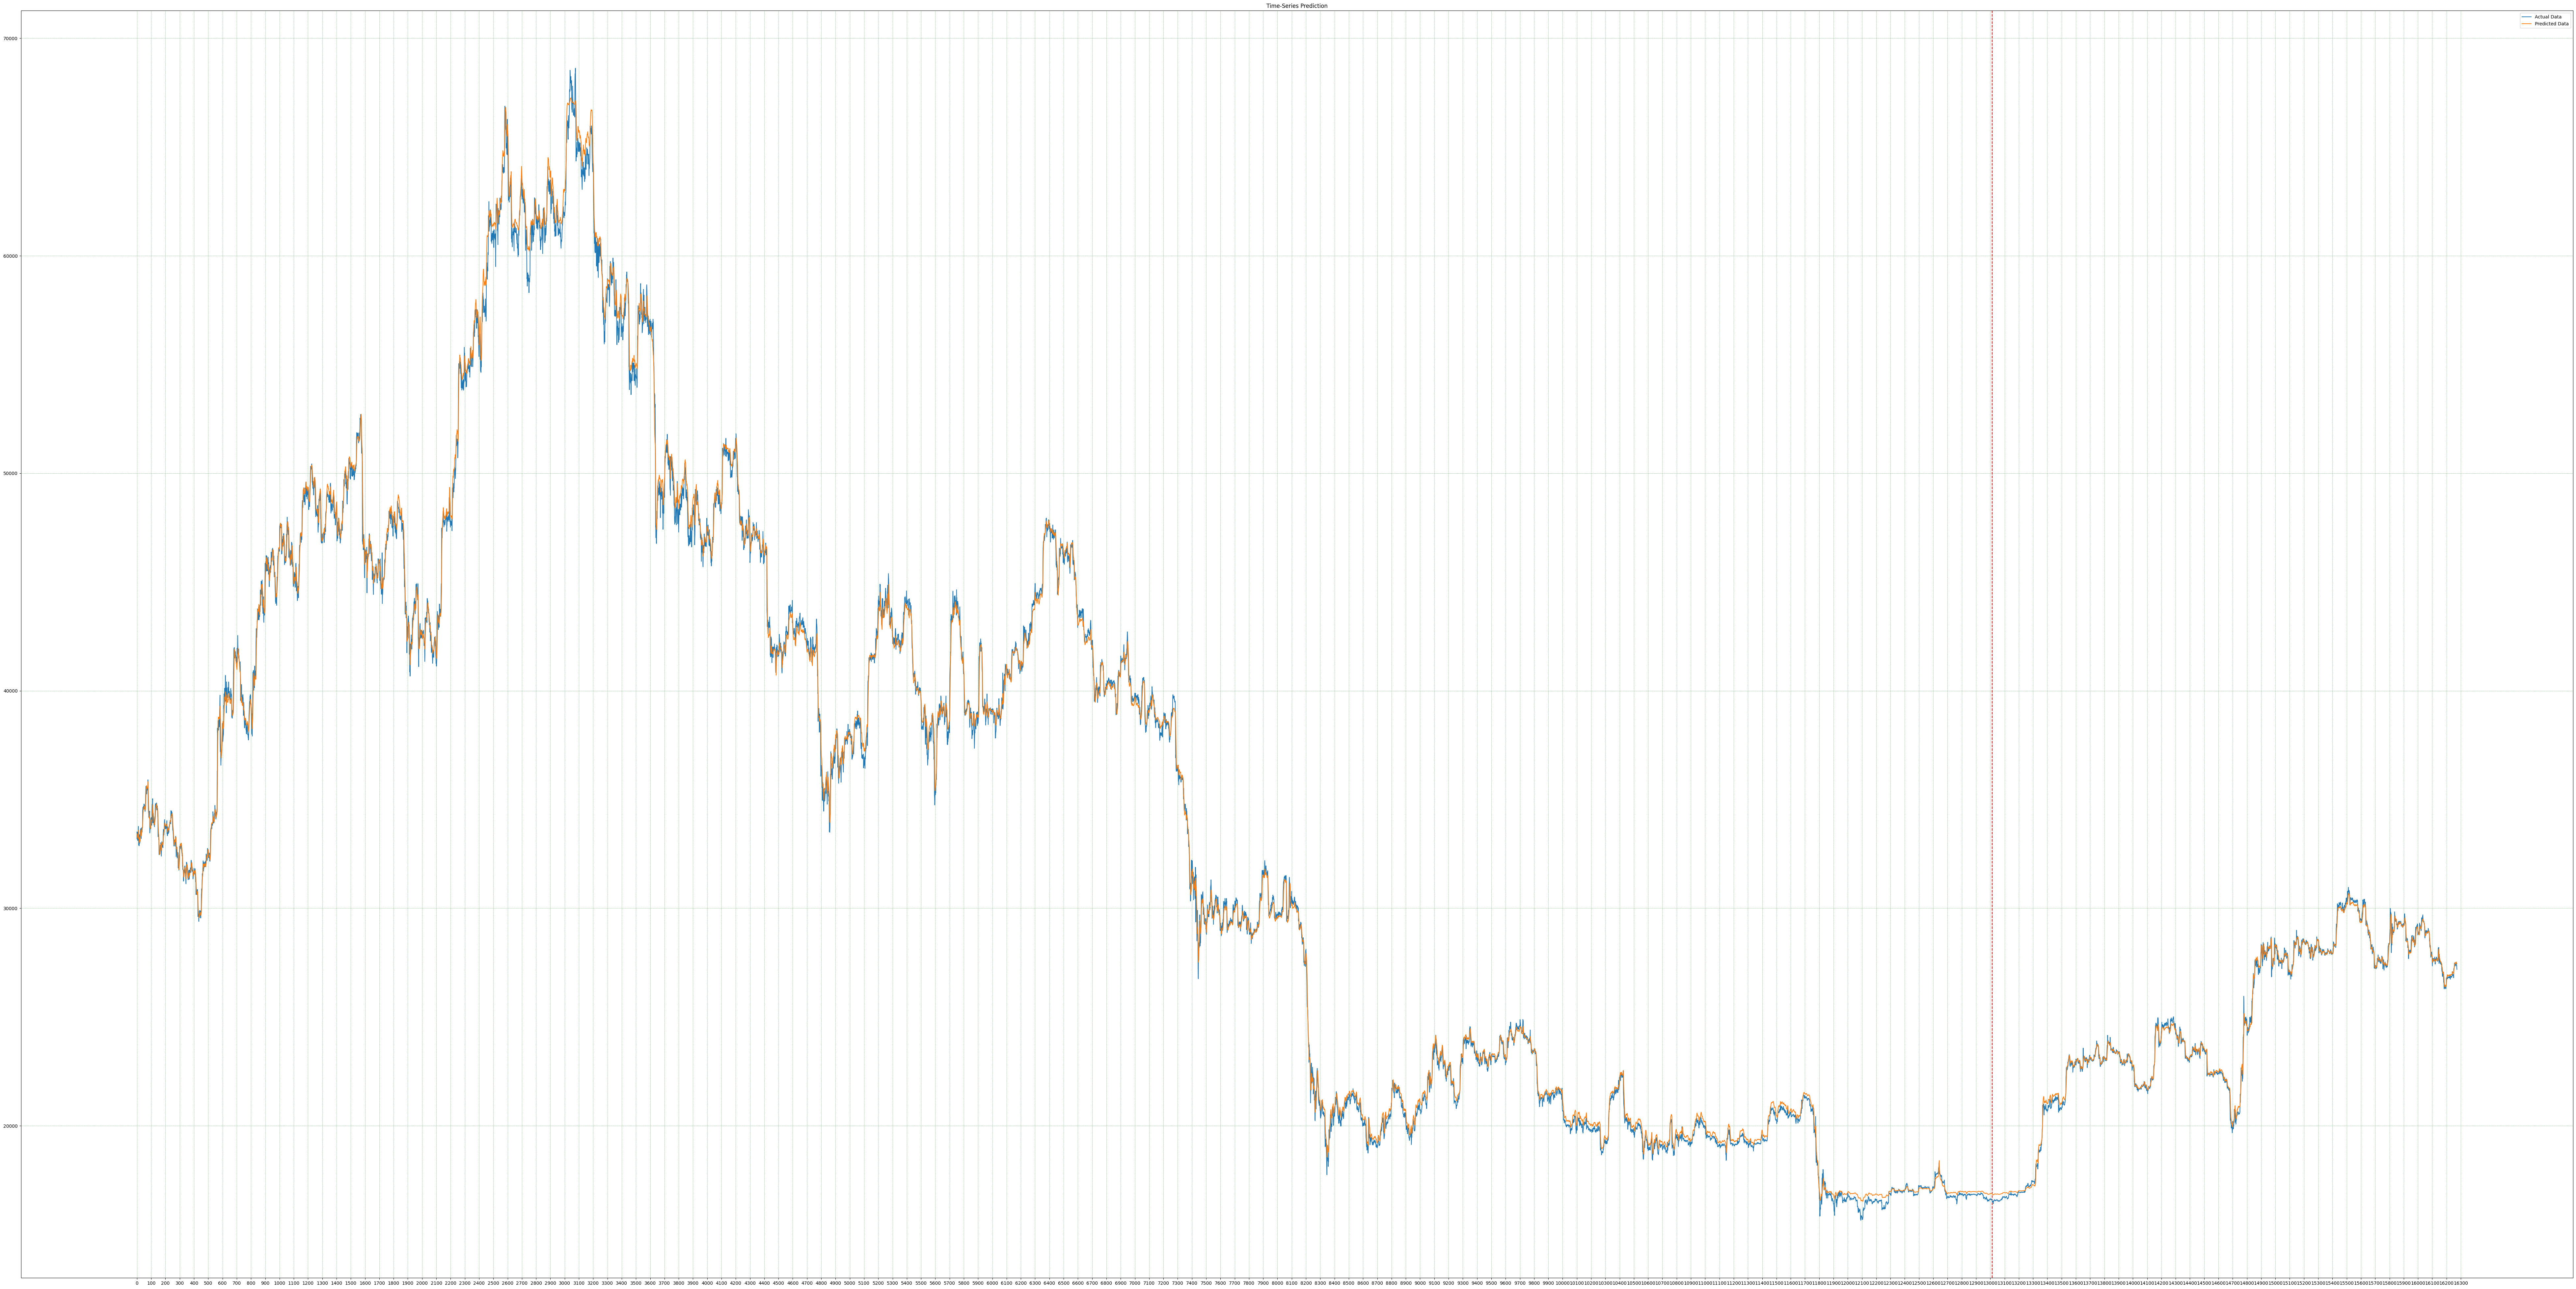

In [31]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])


df_X_ss = SScaler.transform(pd.DataFrame(np.array(Y).reshape(-1, 1))) # old transformers

df_C_ss = condscaler.transform(condtemp)#[f_col])


df_y_mm = MMScaler.transform(pd.DataFrame(np.array(Y).reshape(-1, 1)))
df_y_mm = df_y_mm.squeeze()
# split the sequence
df_X_ss, df_C_ss, df_y_mm = split_sequences(df_X_ss, df_C_ss, df_y_mm, x_shape, y_shape)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_C_ss = Variable(torch.Tensor(df_C_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], x_shape, df_X_ss.shape[2]))
df_C_ss = torch.reshape(df_C_ss, (df_C_ss.shape[0], x_shape, df_C_ss.shape[2]))

# train_predict = myModel(df_X_ss.to(device),df_C_ss.to(device)).cpu() # forward pass

# data_predict = train_predict.data.numpy() # numpy conversion
# dataY_plot = df_y_mm.data.numpy()

# data_predict = MMScaler.inverse_transform(data_predict) # reverse transformation
# dataY_plot = dataY_plot.squeeze()
# dataY_plot = MMScaler.inverse_transform(dataY_plot)
# true, preds = [], []
# for i in range(len(dataY_plot)):
#     true.append(dataY_plot[i][0])
# for i in range(len(data_predict)):
#     preds.append(data_predict[i][0])


# plt.figure(figsize=(30,15)) #plotting
# plt.axvline(x=train_test_cutoff -(x_shape), c='r', linestyle='--') # size of the training set

# plt.xticks(range(0,total_samples,100))
# plt.grid(color='g', linestyle=':', linewidth=0.5)
# plt.plot(true, label='Actual Data') # actual plot
# plt.plot(preds, label='Predicted Data') # predicted plot
# plt.title('Time-Series Prediction')
# plt.legend()
# # plt.savefig("whole_plot.png", dpi=300)
# plt.show()

predict_loader = DataLoader(TensorDataset(df_X_ss, df_C_ss), batch_size=1000)

# make predictions for each batch and concatenate the results
predictions = []
i=0
with torch.no_grad():
  for X_batch, C_batch in predict_loader:
      # print(i)
      # pdb.set_trace()
      # i+=1
      prediction_batch = myModel(X_batch.to(device), C_batch.to(device)).cpu()
      predictions.append(prediction_batch)
predictions = torch.cat(predictions)

# convert predictions and ground truth to numpy arrays
predicted_values = predictions.data.numpy().squeeze()
ground_truth = df_y_mm.data.numpy().squeeze()

# inverse transform the data to get the original scale
predicted_values = MMScaler.inverse_transform(predicted_values)
ground_truth = MMScaler.inverse_transform(ground_truth)

true, preds = [], []
for i in range(len(ground_truth)):
    true.append(ground_truth[i][0])
for i in range(len(predicted_values)):
    preds.append(predicted_values[i][0])


plt.figure(figsize=(100,50)) #plotting
plt.axvline(x=train_test_cutoff -(x_shape), c='r', linestyle='--') # size of the training set

# plot the results
plt.xticks(range(0,total_samples,100))
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

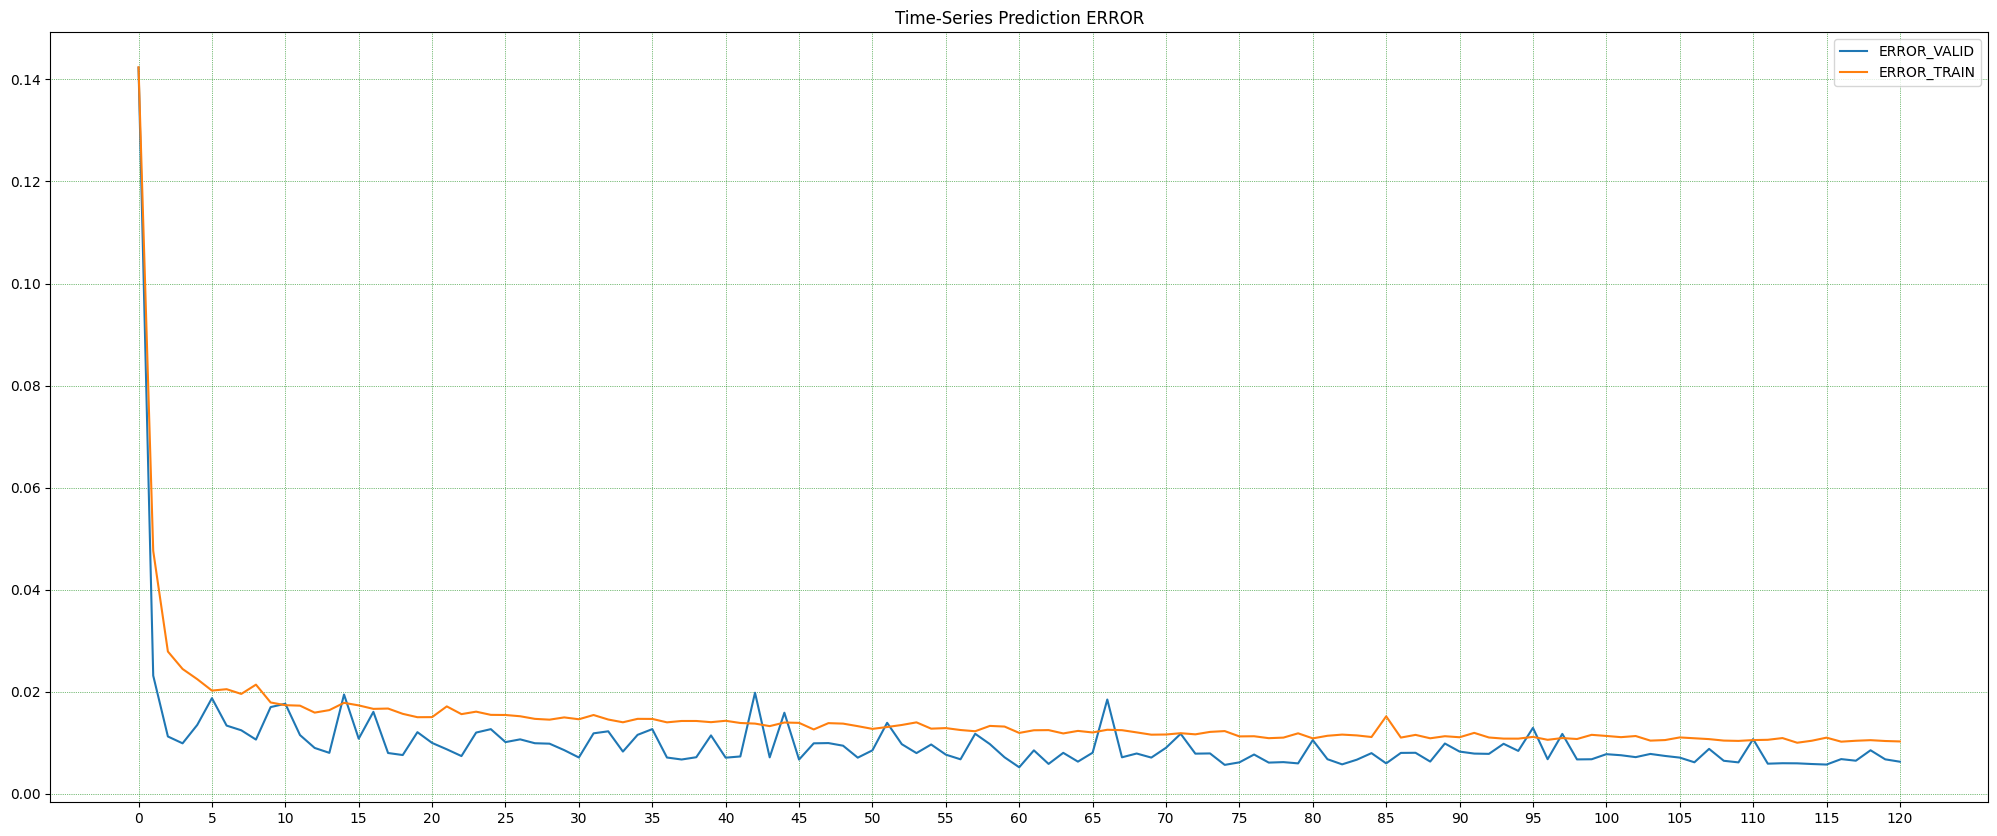

In [32]:
plt.figure(figsize=(25,10)) #plotting
plt.plot(loss_valid_show, label='ERROR_VALID')
plt.plot(loss_train_show, label='ERROR_TRAIN')
plt.title('Time-Series Prediction ERROR')
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.xticks(range(0,n_epochs+1,5))
plt.legend()
plt.show()
# print(loss_show)


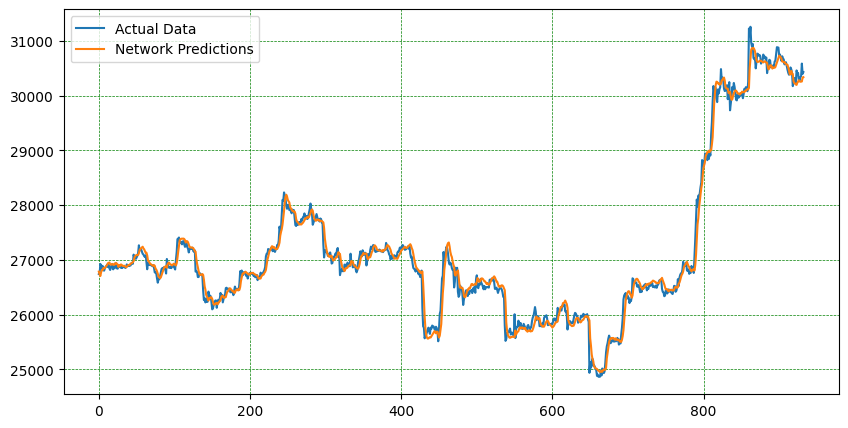

In [34]:
plt.figure(figsize=(10,5)) #plotting
with torch.no_grad():
  test_predict = myModel(DataX_test, DataC_test)  # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = MMScaler_test.inverse_transform(test_predict)
first_day_test_predict = test_predict[:, 0]  # get the first day of the 7-day predictions

test_target = Datay_test.detach().cpu().numpy()  # last sample again
test_target = MMScaler_test.inverse_transform(test_target.flatten().reshape(1, -1))
first_day_test_target = test_target[:, ::y_shape]  # get the corresponding first day in true price

plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.plot(first_day_test_target[0], label="Actual Data")
plt.plot(first_day_test_predict, label="Network Predictions")
plt.legend()
plt.show()

In [ ]:
from pytz import timezone
def reshape_df(df,l=90):
    a = list()
    for i in range(len(df)-l+1):
        seq_x = df[i:l+i]
        a.append(seq_x)
    print(np.array(a).shape)
    return a

x_len=90
from datetime import datetime, timedelta
end=datetime.now()- timedelta(hours=1) #timedelta(hours=1 , minutes=2)
start = end - timedelta(hours=x_len+5)

try :
    top15_test = yf.download("ADA-USD AVAX-USD BNB-USD BTC-USD DOGE-USD DOT-USD ETH-USD LTC-USD MATIC-USD SHIB-USD SOL-USD TRX-USD USDC-USD USDT-USD XRP-USD" ,start=start, end=end , interval ="1h") #1137
except Exception as e:
    print("error")

# top15_test[('Adj Close',)]
top15_test = top15_test.drop([('High',)],axis=1)
top15_test = top15_test.drop([('Low',)],axis=1)
top15_test = top15_test.drop([('Open',)],axis=1)
top15_test = top15_test.drop([('Adj Close',)],axis=1)

top15_test = top15_test.rename_axis('time_stamp')
top15_test = top15_test.replace(0, np.nan)#.fillna(method='ffill')
top15_test = top15_test.fillna(method='bfill')

top15_close = top15_test[('Close',)]
top15_volume = top15_test[('Volume',)]
new_columns = top15_volume.columns.map(lambda x: x.split('-')[0] + '-volume')
top15_volume = top15_volume.rename(columns=dict(zip(top15_volume.columns, new_columns)))

new_columns = top15_volume.columns.map(lambda x: x.split('-')[0] + '-volume')
top15_volume = top15_volume.rename(columns=dict(zip(top15_volume.columns, new_columns)))


col = list(top15_close.columns)+ list(top15_volume.columns)
top15_crypto = pd.DataFrame(np.hstack((top15_close , top15_volume)))
top15_crypto.columns =col

top15_crypto.index = top15_test.index
top15_crypto = top15_crypto.rename(columns={'BTC-USD': 'price_usd_close'})
top15_crypto = top15_crypto.fillna(method='ffill')

xtest = top15_crypto.price_usd_close[-(x_len+1):]
condtest = top15_crypto.drop("price_usd_close",axis=1)[-(x_len+1):]
ytest = top15_crypto.price_usd_close[-(x_len+1):]

MMScaler_test = MinMaxScaler()
SScaler_test = StandardScaler()
condscaler_test = StandardScaler()

X_trans_test = SScaler_test.fit_transform(xtest.values.reshape(-1, 1))
c_trans_test = condscaler_test.fit_transform(condtest.values)
y_trans_test = MMScaler_test.fit_transform(ytest.values.reshape(-1, 1))

X_trans_test = reshape_df(X_trans_test,90)
c_trans_test = reshape_df(c_trans_test,90)
y_trans_test = reshape_df(y_trans_test,90)

X_trans_test = Variable(torch.Tensor(X_trans_test).to(device))
c_trans_test = Variable(torch.Tensor(c_trans_test).to(device))


In [ ]:
# checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
# myModel.load_state_dict(checkpoint['state_dict'])
checkpoint = torch.load('./weights/model_epoch_53.pth', map_location=torch.device('cpu'))
myModel.load_state_dict(checkpoint['state_dict'])

with torch.no_grad():
    test_predict = myModel(X_trans_test , c_trans_test)  # get the last sample
test_predict = MMScaler_test.inverse_transform(test_predict.cpu().detach().numpy())
# first_day_test_predict = test_predict[:, 0]  # get the first day of the 7-day predictions

print(test_predict[0][0],test_predict[1][0])#,test_predict[2][0],test_predict[3][0],test_predict[4][0])
# print("",test_predict[0],"\n 00000.000",test_predict[1])

from datetime import timedelta
for i in range(7):
    t = pd.Timestamp(top15_test.index[-1])
    t = t + timedelta(hours=4+i, minutes=30)
    print("at ",t.strftime('%Y-%m-%d %H:%M:%S')," predicted price: ",test_predict[-1][i])

#2023-07-02 20:00:00 30559.683594

print(test_predict[1][0]- test_predict[0][0] > 0)
for i in range(6):
    print(test_predict[-1][i+1]- test_predict[-1][i] > 0)



In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/logs

In [ ]:
# !pip install pytorch-model-summary
# import pytorch_model_summary as pms
# pms.summary(myModel, torch.zeros(X.shape[0], 30, X.shape[1]).to(device),torch.zeros(X.shape[0], 30, X.shape[1]).to(device), show_input=True, print_summary=True)

In [ ]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])
# DataX_test, DataC_test, Datay_test

predict = myModel(DataX_test, DataC_test)
predict = predict.detach().cpu().numpy()
predict = MMScaler_test.inverse_transform(predict)
# predict = predict[-100:]
true = np.squeeze(Datay_test)
true = MMScaler_test.inverse_transform(true.cpu())
# true = true[-100:]

# calculate the daily returns based on the predicted and true prices
predict_returns = (predict[:, 1:] - predict[:, :-1]) / predict[:, :-1]
true_returns = (true[:, 1:] - true[:, :-1]) / true[:, :-1]

# calculate the position you would have taken based on your prediction
threshold = 0.00001  # 1% return threshold
predict_position = np.where(predict_returns > threshold, 1, -1)
true_position = np.where(true_returns > threshold, 1, -1)

# define a function to simulate the portfolio based on the predicted or true returns
def simulate_portfolio(position, returns, initial_capital):
    # calculate the daily profit and loss based on the position you took and the daily returns
    transaction_cost = 0.001  # 0.1% per transaction
    position_percentage = 0.2  # 10% of capital
    pnl = position * (initial_capital * position_percentage) * (returns - transaction_cost)

    # calculate the cumulative PnL over the entire period
    cumulative_pnl = np.cumsum(pnl)

    # calculate the final portfolio value
    final_value = initial_capital + cumulative_pnl[-1]

    # calculate the profit percentage
    profit_percentage = ((final_value - initial_capital) / initial_capital) * 100

    return final_value, profit_percentage

# simulate the portfolio based on the predicted and true returns for different initial capital values
for cap in [1000, 2000, 5000, 10000]:
    print(f"\nFor initial capital of {cap}:")
    predict_final_value, predict_profit_percentage = simulate_portfolio(predict_position, predict_returns, cap)
    true_final_value, true_profit_percentage = simulate_portfolio(true_position, true_returns, cap)
    print(f"Predicted final value   : {predict_final_value:.2f} with {predict_profit_percentage:.2f}% profit")
    print(f"True final value        : {true_final_value:.2f} with {true_profit_percentage:.2f}% profit")
    print(f"(Predicted/True)% profit: {predict_final_value*100/true_final_value:.2f}% profit")
    print("-----------------------------------------------------------")

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
param_grid = {
    'kernel_size_EN': [2],
    'kernel_size_DE': [2],
    'hidden_size_lstm': [5,10,15,20],
    'hidden_size_gru': [5,10,15,20],
    'num_levels_en': [4],
    'num_levels_de': [4],
    'num_layers_lstm': [6],
    'num_layers_gru': [4]
}
loss_fn = RMSLELoss
lr_decay_epoch = 41
learning_rate = 0.01
weight_decay = 0.0001
n_epochs = 121
batch_size = 2000

def RMSLELoss_test(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = np.sqrt(np.mean((np.log(y_pred+1) - np.log(y_true+1))**2))
  return loss

def NRMSELoss_test(yhat,y): #NRMSE
    return (np.sqrt(np.mean(np.square(yhat-y))))/ (np.max(y) - np.min(y))

def run_experiment(params):
    myModel = TSASeriesNet.ANNmodel(X_train_tensors_final.shape[1], C_train_tensors_final.shape[2], X_train_tensors_final.shape[2],y_train_tensors.shape[1],
                                    params['num_levels_en'], params['num_levels_de'], params['kernel_size_EN'],
                                    params['kernel_size_DE'], 2, params['hidden_size_lstm'], params['hidden_size_gru'],
                                    params['num_layers_lstm'], params['num_layers_gru']).to(device)

    optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=0.0001)#, weight_decay=weight_decay, lr=learning_rate)

    loss_train_show ,loss_valid_show , best_valid_loss , best_epoch= training_loop(
                                  n_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  lr_decay_epoch = lr_decay_epoch,
                                  network=myModel,
                                  optimiser=optimiser,
                                  loss_fn=loss_fn,
                                  X_train=X_train_tensors_final,
                                  Condition_train = C_train_tensors_final,
                                  y_train=y_train_tensors,
                                  X_test=X_test_tensors_final,
                                  Condition_test  = C_test_tensors_final,
                                  y_test=y_test_tensors,
                                  batch_size = batch_size)

    checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
    myModel.load_state_dict(checkpoint['state_dict'])

    with torch.no_grad():
        test_predict = myModel(DataX_test, DataC_test)  # get the last sample
    test_predict = test_predict.detach().cpu().numpy()

    test_target = Datay_test.detach().cpu().numpy()  # last sample again



    RMSLELoss_res = RMSLELoss_test(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )
    print("****TEST*** ",RMSLELoss_res)



    return loss_valid_show[-1]

import itertools

def grid_search(param_grid):
    keys, values = zip(*param_grid.items())
    min_loss = float('inf')
    best_params = None

    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        print(f"Running experiment with parameters: {params}")
        loss = run_experiment(params)
        print(f"Validation loss: {loss}")

        if loss < min_loss:
            min_loss = loss
            best_params = params

    return best_params, min_loss

best_params, min_loss = grid_search(param_grid)
print(f"Best parameters: {best_params}")
print(f"Minimum validation loss: {min_loss}")


Running experiment with parameters: {'kernel_size_EN': 2, 'kernel_size_DE': 2, 'hidden_size_lstm': 5, 'num_levels_en': 4, 'num_levels_de': 4, 'num_layers_lstm': 6, 'num_layers_gru': 4}
Epoch:    0, Train loss: 0.60749, Validation loss: 0.34019
Epoch:    5, Train loss: 0.24729, Validation loss: 0.12294
Epoch:   10, Train loss: 0.21615, Validation loss: 0.11542
Epoch:   15, Train loss: 0.20141, Validation loss: 0.11186
Epoch:   20, Train loss: 0.15170, Validation loss: 0.06177
Epoch:   25, Train loss: 0.08887, Validation loss: 0.04104
Epoch:   30, Train loss: 0.07500, Validation loss: 0.03180
Epoch:   35, Train loss: 0.06793, Validation loss: 0.02527
Epoch:   40, Train loss: 0.06226, Validation loss: 0.02567
Epoch:   45, Train loss: 0.05869, Validation loss: 0.01162
Epoch:   50, Train loss: 0.05531, Validation loss: 0.01114
Epoch:   55, Train loss: 0.05247, Validation loss: 0.00991
Epoch:   60, Train loss: 0.05045, Validation loss: 0.00840
Epoch:   65, Train loss: 0.04822, Validation los

In [ ]:
# import backtrader as bt
# import pandas as pd

# checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
# myModel.load_state_dict(checkpoint['state_dict'])
# # DataX_test, DataC_test, Datay_test

# predict = myModel(DataX_test, DataC_test)
# predict = predict.detach().cpu().numpy()
# predict = pd.DataFrame(MMScaler_test.inverse_transform(predict))
# predict.index = data.index[-106:]
# predict = predict.rename_axis("datetime")

# # predict = predict[-100:]
# true = np.squeeze(Datay_test)
# true = pd.DataFrame(MMScaler_test.inverse_transform(true.cpu()))
# true.index = data.index[-106:]
# true = true.rename_axis("datetime")

# # Load the predicted data
# predicted_data = pd.DataFrame(predict[0])
# predicted_data = predicted_data.rename(columns={0: 'predicted'})
# # predicted_data.index = data.index[-143:]
# # Load the true data
# true_data = pd.DataFrame(true[0])
# true_data = true_data.rename(columns={0: 'true'})
# # true_data.index = data.index[-143:]
# # Define the strategy
# class NeuralNetStrategy(bt.Strategy):
#     params = (
#         ('threshold', 0.05),
#     )

#     def __init__(self):
#         self.data_predicted = self.datas[0]
#         self.data_true = self.datas[1]

#     def next(self):
#         if self.data_predicted.close[0] > self.data_true.close[0] * (1 + self.params.threshold):
#             self.buy()
#         elif self.data_predicted.close[0] < self.data_true.close[0] * (1 - self.params.threshold):
#             self.sell()

# # Create a cerebro instance
# cerebro = bt.Cerebro()

# # Add the predicted data
# predicted_data_feed = bt.feeds.PandasData(dataname=predicted_data)
# cerebro.adddata(predicted_data_feed, name='predicted')

# # Add the true data
# true_data_feed = bt.feeds.PandasData(dataname=true_data)
# cerebro.adddata(true_data_feed, name='true')

# # Add the strategy
# cerebro.addstrategy(NeuralNetStrategy, threshold=0.05)

# # Set the cash and commission
# cerebro.broker.setcash(1000.0)
# cerebro.broker.setcommission(commission=0.001)

# # Run the backtest
# cerebro.run()

# # Print the final portfolio value
# print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())